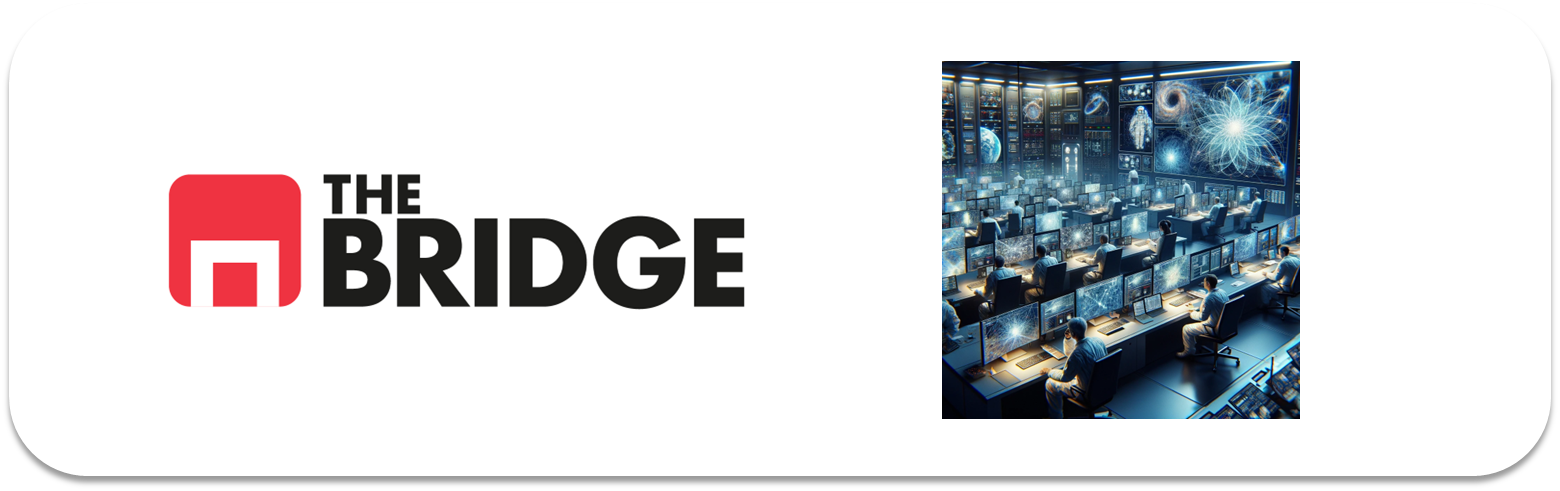

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import os
from skimage.io import imread
import cv2

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [2]:
def read_data(directorio, reshape_dim = (32,32)):
    X = []
    y = []
    for folder in os.listdir(directorio):
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
                nombre = file.split('.')[0]

                X.append(image)
                y.append(nombre)

    return np.array(X),np.array(y)

In [3]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "github_train/"
TEST_PATH = ROOT_PATH + "github_test/"

In [4]:
X_train, y_train = read_data(TRAIN_PATH)

In [ ]:
# necesito otra funcion porque las imagenes no tienen la misma estrucutra de ruta que el train

In [5]:
def read_data_test(directorio, reshape_dim = (32,32)):
    X = []
    y = []

    for file in os.listdir(directorio):
        imagen = os.path.join(directorio, file)
        image = imread(imagen)
        image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32
        nombre = file.split('.')[0]

        X.append(image)
        y.append(nombre)

    return np.array(X),np.array(y)

In [6]:
X_test, y_test = read_data_test(TEST_PATH)

In [ ]:
# vamos a ver el target

In [7]:
target = pd.Series(y_train)

In [8]:
target.value_counts()

cat    2000
dog    2000
Name: count, dtype: int64

In [ ]:
# está igualado

In [ ]:
#miramos el shape de las imagenes y el size del dataset

In [9]:
X_train.shape

(4000, 32, 32, 3)

In [10]:
X_train.size

12288000

In [ ]:
# son 12Millones, usaremos Adam como optimizador

In [ ]:
# vamos a ver algunas imagenes

In [11]:
def imagenes_visual(imagen, labels, inicio, final):
    cantidad = final - inicio
    cols = 3
    filas = (cantidad + cols -1) // cols
    plt.figure(figsize=(10,10))
    for a,x in enumerate(range(inicio,final)):
        plt.subplot(filas, cols, a +1)
        plt.imshow(imagen[x], cmap = 'Greys')
        plt.title(labels[x])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

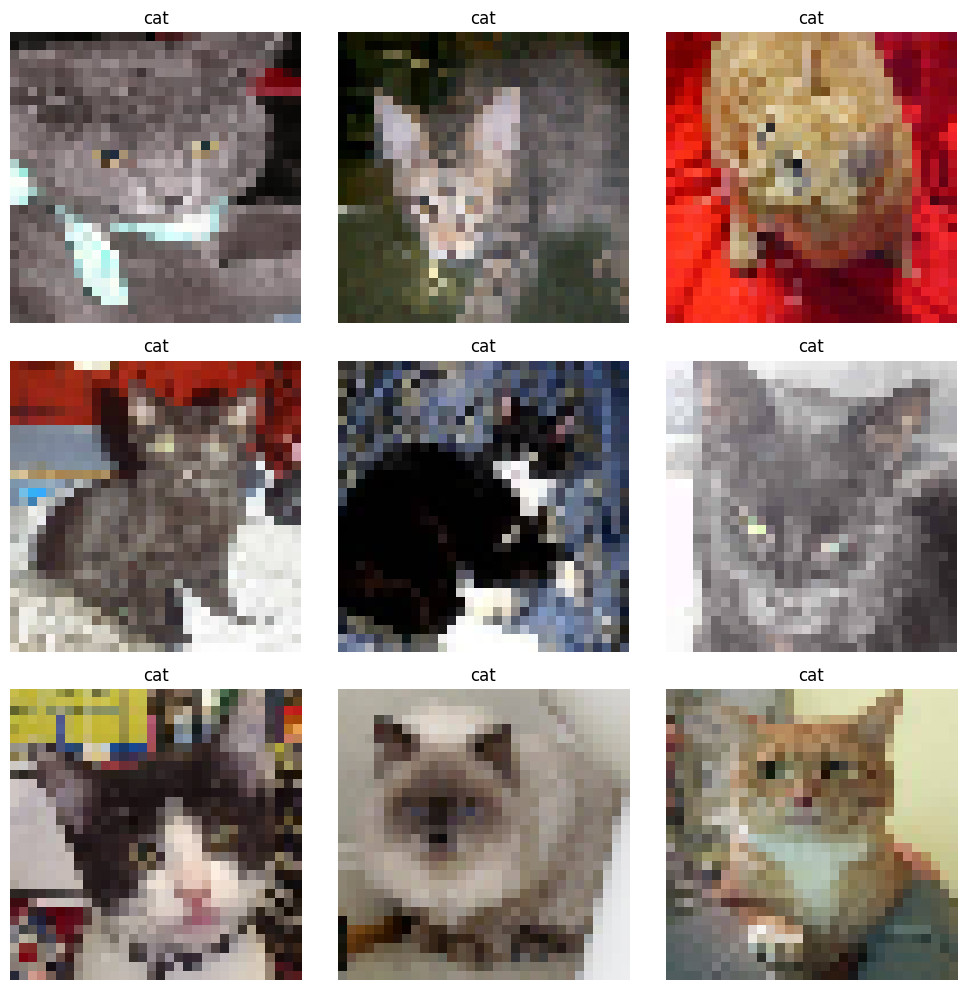

In [12]:
imagenes_visual(X_train, y_train, 255, 264)

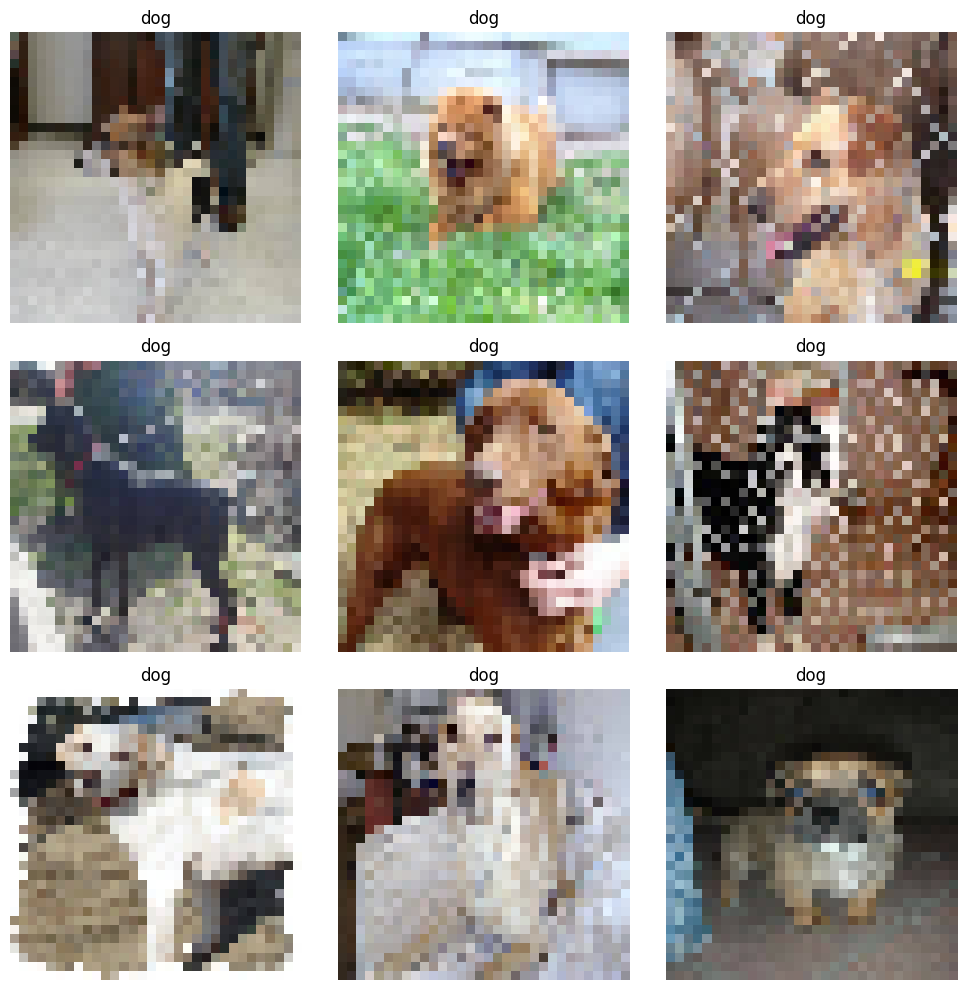

In [13]:
imagenes_visual(X_train, y_train, 2455, 2464)

In [ ]:
# normalizamos los valores

In [15]:
X_train_ = X_train/255
X_test_ = X_test/255

In [ ]:
# vamos a codificar el target

In [21]:
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
y_train = y_train.apply(lambda x: 0 if x == 'cat' else 1)
y_test = y_test.apply(lambda x: 0 if x == 'cat' else 1)

In [ ]:
# Creamos el modelo

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

In [109]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size=(3,3), padding='same', activation= 'relu', input_shape= (32,32,3)))
print('Pesos', 30 * (3*3+1))
print('resolucion', 32*32*30)
model.add(MaxPool2D(pool_size=(2,2), strides= (2,2)))
# dropout
model.add(Dropout(rate = 0.25))
print('resolucion', ((32/2) * (32/2) * 30) / 4)
# siguiente juego Convolucional-Pooling
model.add(Conv2D(filters = 64, kernel_size=(3,3), padding='same', activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(rate = 0.25))

Pesos 300
resolucion 30720
resolucion 1920.0


In [ ]:
# donde se va a hacer la clasificacion

In [110]:
model.add(Flatten())
model.add(Dense(128, activation  ='relu'))
model.add(Dropout(0.50))
model.add(Dense(1, activation = 'sigmoid')) # clase binaria

In [111]:
optimizer = Adam(learning_rate =0.00001, beta_1=0.9, beta_2=0.999)

In [ ]:
# compilamos

In [112]:
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=["accuracy"])

In [113]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 543,937 (2.07 MB)

 Trainable params: 543,937 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# vamos a entrenar el modelo

In [114]:
batch_size = 32 # se divide en grupos de 20
epochs = 50 # verá todos los datos 150 veces
validation_split = 0.2

In [106]:
from sklearn.utils import shuffle

In [115]:
X_train__, y_train__ = shuffle(X_train_, y_train)

In [116]:
history = model.fit(X_train__, y_train__, batch_size = batch_size, epochs= epochs, validation_split = validation_split,
                   callbacks=[keras.callbacks.EarlyStopping(patience=8, # las epocas que espera sin mejorar
                                             restore_best_weights=True)])# asi usan los pesos con el mejor 'val_loss'

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5172 - loss: 0.7035 - val_accuracy: 0.5575 - val_loss: 0.6903
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5211 - loss: 0.6965 - val_accuracy: 0.5500 - val_loss: 0.6896
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5353 - loss: 0.6934 - val_accuracy: 0.5575 - val_loss: 0.6890
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5050 - loss: 0.6951 - val_accuracy: 0.5600 - val_loss: 0.6882
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5223 - loss: 0.6959 - val_accuracy: 0.5675 - val_loss: 0.6878
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5444 - loss: 0.6901 - val_accuracy: 0.5587 - val_loss: 0.6878
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5302 - loss: 0.6948 - val_accuracy: 0.5600 - val_loss: 0.6875
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5280 - loss: 0.6913 - val_accu

In [117]:
df_history = pd.DataFrame(history.history)

<Axes: >

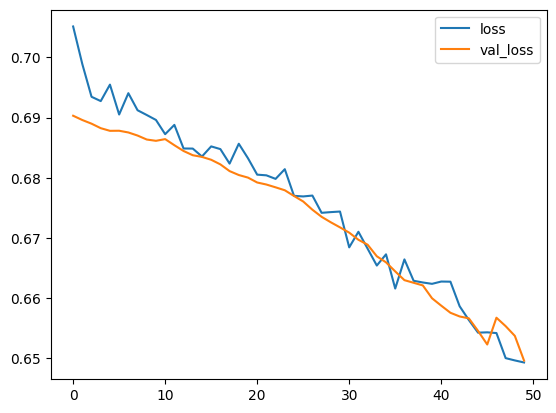

In [118]:
df_history[['loss', 'val_loss']].plot()

<Axes: >

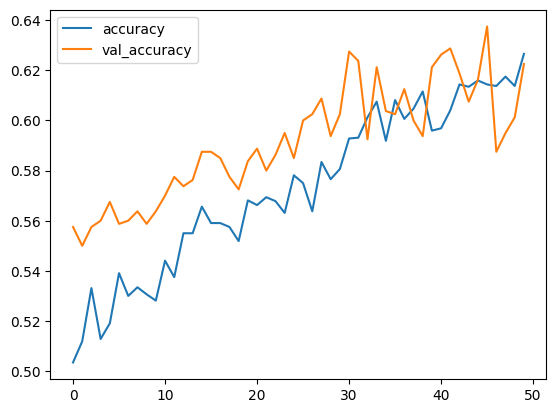

In [119]:
df_history[['accuracy', 'val_accuracy']].plot()

In [166]:
# evaluamos contra test

In [120]:
model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3434 - loss: 54.5610


[34.11204528808594, 0.578000009059906]

In [121]:
y_pred = [np.argmax(predictions) for predictions in model.predict(X_test)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [48]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [122]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       500
           1       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


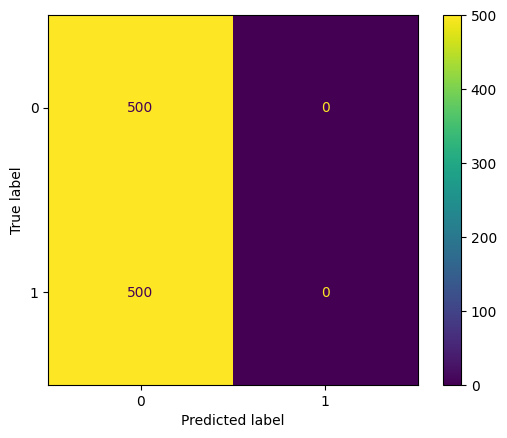

In [123]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
X_tes

In [124]:
confianza = [prediction.max() for prediction in model.predict(X_test_)]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [127]:
pred_df = pd.DataFrame({"True": y_test, "Predicted": y_pred, "Confianza": confianza})

In [128]:
error = pred_df["True"] != pred_df["Predicted"]
errores = pred_df[error].sort_values("Confianza", ascending = False)
errores

,True,Predicted,Confianza
811,1,0,0.796435
844,1,0,0.750122
976,1,0,0.745462
889,1,0,0.743912
574,1,0,0.733160
...,...,...,...
624,1,0,0.409459
680,1,0,0.404436
834,1,0,0.403838
832,1,0,0.394357
